### Individual ACS Data

[Documentation](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2015-2019.pdf)

##### Importing Libraries

In [1]:
import os
import sys
sys.path[0] = os.path.join(os.path.abspath(''),'..')  # make sure we can import from our package

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_pipeline import fetch_census_data

In [3]:
# If you updated variables in config.ini, rerun the next line to fetch the latest changes 
# fetch_census_data.acs5_individual(force_api_call=True)

##### Importing Data

In [6]:
# loading individual acs data

acs_ind = fetch_census_data.acs5_individual()
acs_ind.head(5)

,Unnamed: 0,internet_access,broadband,family_income,hh_income,poverty,race,hispanic,pop_65,weight,employment,work_available,education,citizenship,public use microdata area
0,0,1,1,-60000,1000,8,1,1,0,47,1,5,16,4,3520
1,1,1,1,-60000,96000,501,2,1,0,29,1,5,22,1,3501
2,2,1,1,366000,366000,501,1,1,0,15,1,5,21,1,3420
3,3,1,1,366000,366000,501,6,1,0,13,1,5,21,1,3420
4,4,1,1,366000,366000,501,9,1,0,14,0,0,8,1,3420


##### Recoding Variables

Education

In [7]:
#checking for all outcomes of the education variable

acs_ind.education.unique()

array([16, 22, 21,  8,  3,  0, 13, 19, 14, 10, 20, 23,  6, 11,  9, 18, 15,
       12,  7,  5, 17,  1,  2,  4, 24])

In [8]:
# collapse education to 1,2,3 (<=high school, some college, >=bachelors) for easier regression

acs_ind.loc[(acs_ind.education <= 17),'education']=1
acs_ind.loc[(acs_ind.education == 18),'education']=2
acs_ind.loc[(acs_ind.education == 19),'education']=2
acs_ind.loc[(acs_ind.education == 20),'education']=2
acs_ind.loc[(acs_ind.education >= 21),'education']=3

In [9]:
# checking to make sure the previous cell worked 

acs_ind.education.unique()

array([1, 3, 2])

Citizenship/Foreign-born

In [10]:
# 1. Born in the U.S.
# 2. Born in Puerto Rico, Guam, the U.S. Virgin Islands, or the Northern Marianas
# 3. Born abroad of American parent(s)
# 4. U.S. citizen by naturalization
# 5. Not a citizen of the U.S.

acs_ind.citizenship.unique()

array([4, 1, 5, 2, 3])

In [11]:
# 1

born_citizen_df = acs_ind[["Unnamed: 0","citizenship"]].rename(columns={
                        "citizenship": "born_citizen"})

In [12]:
born_citizen_df.loc[(born_citizen_df.born_citizen != 1),'born_citizen']=0
born_citizen_df.loc[(born_citizen_df.born_citizen == 1),'born_citizen']=1

In [13]:
# 5

non_citizen_df = acs_ind[["Unnamed: 0","citizenship"]].rename(columns={
                        "citizenship": "non_citizen"})

In [14]:
non_citizen_df.loc[(non_citizen_df.non_citizen != 5),'non_citizen']=0
non_citizen_df.loc[(non_citizen_df.non_citizen == 5),'non_citizen']=1

In [15]:
# 2,3,4

foreign_citizen_df = acs_ind[["Unnamed: 0","citizenship"]].rename(columns={
                        "citizenship": "foreign_citizen"})

In [16]:
foreign_citizen_df.loc[(foreign_citizen_df.foreign_citizen == 1),'foreign_citizen']=0
foreign_citizen_df.loc[(foreign_citizen_df.foreign_citizen == 2),'foreign_citizen']=1
foreign_citizen_df.loc[(foreign_citizen_df.foreign_citizen == 3),'foreign_citizen']=1
foreign_citizen_df.loc[(foreign_citizen_df.foreign_citizen == 4),'foreign_citizen']=1
foreign_citizen_df.loc[(foreign_citizen_df.foreign_citizen == 5),'foreign_citizen']=0

In [17]:
# joining all citizen outcomes back into the main df

acs_ind=acs_ind.merge(born_citizen_df, on='Unnamed: 0'
                           ).merge(non_citizen_df, on='Unnamed: 0').merge(foreign_citizen_df, on='Unnamed: 0')

Population 65+

In [18]:
# we see there's a -1 in the responses, which means no response 

acs_ind.pop_65.unique()

array([ 0,  1, -1,  2])

In [19]:
# getting rid of all -1 rows

acs_ind = acs_ind[acs_ind['pop_65'] >= 0]

In [20]:
# 0 No person 65 and over
# 1 person 65 and over
# 2 or more persons 65 and over

acs_ind.loc[(acs_ind.pop_65 >= 1),'pop_65']=1

In [21]:
acs_ind.pop_65.unique()

array([0, 1])

Internet Access

In [22]:
acs_ind.internet_access.unique()

array([1, 3, 2])

In [23]:
# need to remove the responses with "0" because it means no response

acs_ind = acs_ind[acs_ind['internet_access'] >0]

In [24]:
# recoding internet access
# 0 = no access
# 1 = access 

acs_ind.loc[(acs_ind.internet_access == 2),'internet_access']=1
acs_ind.loc[(acs_ind.internet_access == 3),'internet_access']=0

Hispanic

In [25]:
# recoding hispanic
# 0 = not hispanic
# 1 = hispanic

acs_ind.loc[(acs_ind.hispanic == 1),'hispanic']=0
acs_ind.loc[(acs_ind.hispanic > 1),'hispanic']=1

In [26]:
acs_ind.hispanic.unique()

array([0, 1])

non-Hispanic White, Black, Asian Races

In [27]:
# selecting race, hispanic, and the Unnamed column to join it back into the main df after recoding

black_df = acs_ind[["Unnamed: 0","race","hispanic"]].rename(columns={
                        "race": "black"})

In [28]:
# recoding black to dummy variables

black_df.loc[(black_df.black != 2),'black']=0
black_df.loc[(black_df.black == 2),'black']=1

In [29]:
# making sure previous cell worked 

black_df.black.unique()

array([0, 1])

In [30]:
# setting up columns to extract non-Hispanic black

black_df["nh_black"]=black_df['hispanic']+black_df['black']

In [31]:
# recoding non-Hispanic black

black_df.loc[(black_df.nh_black != 1),'nh_black']=0
black_df.loc[(black_df.nh_black == 1),'nh_black']=1

In [32]:
# making sure previous
black_df.nh_black.unique()

array([0, 1])

In [33]:
black_df=black_df.drop(['hispanic'], axis=1)

In [34]:
white_df = acs_ind[["Unnamed: 0","race", "hispanic"]].rename(columns={
                        "race": "white"})

In [35]:
white_df.loc[(white_df.white != 1),'white']=1
white_df.loc[(white_df.white == 1),'white']=1

In [36]:
white_df.white.unique()

array([1])

In [37]:
white_df["nh_white"]=white_df['hispanic']+white_df['white']

In [38]:
white_df.loc[(white_df.nh_white != 1),'nh_white']=0
white_df.loc[(white_df.nh_white == 1),'nh_white']=1

In [39]:
white_df=white_df.drop(['hispanic'], axis=1)

In [40]:
asian_df = acs_ind[["Unnamed: 0","race", "hispanic"]].rename(columns={
                        "race": "asian"})

In [41]:
asian_df.loc[(asian_df.asian != 6),'asian']=0
asian_df.loc[(asian_df.asian == 6),'asian']=1

In [42]:
asian_df.asian.unique()

array([0, 1])

In [43]:
asian_df["nh_asian"]=asian_df['hispanic']+asian_df['asian']

In [44]:
asian_df.loc[(asian_df.nh_asian != 1),'nh_asian']=0
asian_df.loc[(asian_df.nh_asian == 1),'nh_asian']=1

In [45]:
asian_df=asian_df.drop(['hispanic'], axis=1)

In [46]:
acs_ind=acs_ind.merge(white_df, on='Unnamed: 0'
                           ).merge(black_df, on='Unnamed: 0').merge(asian_df, on='Unnamed: 0')

Household & Family Income

In [47]:
# looking at all family income responses

acs_ind.family_income.unique()

array([ -60000,  366000,  385000, ...,  211900, 1033000,  315300])

In [48]:
# looking at all household income responses

acs_ind.hh_income.unique()

array([   1000,   96000,  366000, ..., 1033000,  315300,   68380])

In [49]:
# keeping incomes above 0 

acs_ind = acs_ind[acs_ind['hh_income'] >0]
acs_ind = acs_ind[acs_ind['family_income'] >0]

In [50]:
# log household and family incomes

acs_ind["log_family_income"]=acs_ind["family_income"].apply(lambda x: np.log(x))
acs_ind["log_hh_income"]=acs_ind["hh_income"].apply(lambda x: np.log(x))

In [51]:
acs_ind.log_family_income.unique()

array([12.81038861, 12.86099861, 11.17759258, ..., 12.26386974,
       13.84797775, 12.66127985])

In [52]:
acs_ind.log_hh_income.unique()

array([12.81038861, 12.86099861, 11.17759258, ..., 12.26386974,
       13.84797775, 12.66127985])

#### Visualizations

<AxesSubplot:xlabel='internet_access', ylabel='log_hh_income'>

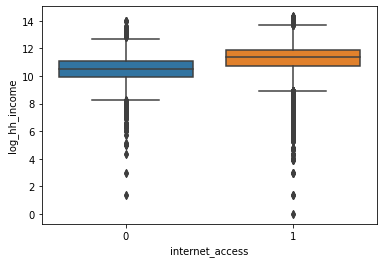

In [53]:
# boxplot of household income and internet access

sns.boxplot(x="internet_access", y="log_hh_income", data=acs_ind)

<AxesSubplot:xlabel='internet_access', ylabel='log_family_income'>

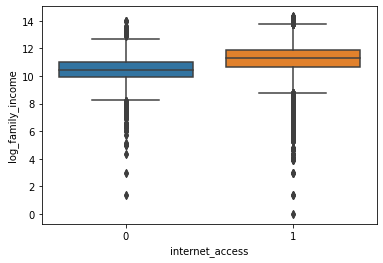

In [54]:
# boxplot of family income and internet access

sns.boxplot(x="internet_access", y="log_family_income", data=acs_ind)

In [55]:
# getting internet access counts 

count_no_int = len(acs_ind[acs_ind['internet_access']==0])
count_int = len(acs_ind[acs_ind['internet_access']==1])
pct_of_int = count_int/(count_no_int+count_int)
print("percentage with internet access is", pct_of_int*100)
pct_of_no_int = count_no_int/(count_no_int+count_int)
print("percentage with no internet access", pct_of_no_int*100)

percentage with internet access is 91.8771715654052
percentage with no internet access 8.122828434594798


##### List of variables that may impact internet access

- household income
- family income
- race
- hispanic
- poverty to income ratio 

### Correlation 

<AxesSubplot:>

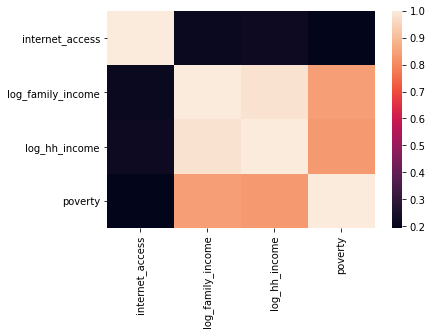

In [56]:
# internet access correlation with family/household income and poverty rate

sns.heatmap(
    acs_ind[['internet_access','log_family_income','log_hh_income','poverty']]
    .corr())

<AxesSubplot:>

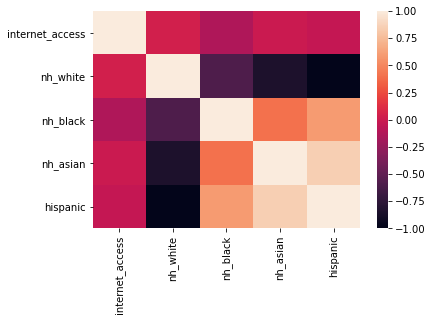

In [57]:
# internet access correlation with white, black, asian, hispanic

sns.heatmap(
    acs_ind[['internet_access','nh_white','nh_black','nh_asian','hispanic']]
    .corr())

<AxesSubplot:>

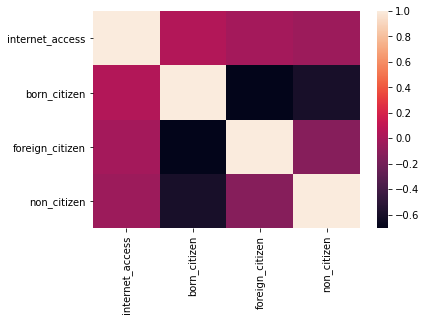

In [58]:
# internet access correlation with us born citizens, foreign citizens, and non citizens

sns.heatmap(
    acs_ind[['internet_access','born_citizen','foreign_citizen','non_citizen']]
    .corr())

<AxesSubplot:>

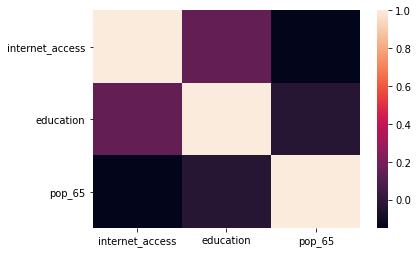

In [59]:
# internet access correlation with education and elderly population

sns.heatmap(
    acs_ind[['internet_access','education','pop_65']]
    .corr())

### Logistic Regression

In [60]:
# importing libraries for logistic regression

from sklearn.model_selection import train_test_split
from statsmodels.formula.api import logit

In [61]:
# setting up columns for normalization 
cols_to_norm = ['log_hh_income','education']

In [62]:
# normalizing columns 

acs_ind[cols_to_norm] = acs_ind[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [63]:
acs_ind.education

2         1.0
3         1.0
4         0.0
5         0.0
6         1.0
         ... 
114613    0.0
114614    0.0
114615    0.0
114616    0.5
114617    0.0
Name: education, Length: 85192, dtype: float64

In [64]:
acs_ind.log_hh_income

2         0.894135
3         0.894135
4         0.894135
5         0.894135
6         0.897667
            ...   
114613    0.787122
114614    0.787122
114615    0.787122
114616    0.556459
114617    0.556459
Name: log_hh_income, Length: 85192, dtype: float64

#### Full Model with All Variables

In [65]:
# using all variables in full logit model

formula=("internet_access ~ log_hh_income + hispanic + nh_asian + nh_black + education + pop_65 + born_citizen + non_citizen")

model=logit(formula=formula, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.240627
         Iterations 8


In [66]:
#normalize all the features (0,1) income + education 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85183
Method:                           MLE   Df Model:                            8
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                  0.1460
Time:                        11:33:02   Log-Likelihood:                -20499.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.4797      0.141    -24.635      0.000      -3.757      -3.203
log_hh_income     7.9771      0.179     44.615      0.000       7.627       8.327
hispanic         -0.3620      0.080     -4.530      0.000      -0.519      -0.205
nh_asian          0.7494      0.076      9.923      0.000       0.601       0.897
nh_black         -0.6081      0.037    -16.443      0.000      -0.681      -0.536
education         1.1144      0.044     25.125      0.000       1.028       1.201
pop_65           -1.1429      0.028    -41.246      0.000      -1.197      -1.089
born_citizen      0.3390      0.042      8.152      0.000       0.257       0.420
non_citizen      -0.3282      0.049     -6.634      0.000      -0.425      -0.231
=================================================================================
"""

#### Group Models

Citizenship

In [67]:
formula1=("internet_access ~ non_citizen + born_citizen")

In [68]:
model1=logit(formula=formula1, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.280584
         Iterations 6


In [69]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85189
Method:                           MLE   Df Model:                            2
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                0.004171
Time:                        11:33:02   Log-Likelihood:                -23904.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                 3.315e-44
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.3247      0.032     71.620      0.000       2.261       2.388
non_citizen     -0.3274      0.046     -7.082      0.000      -0.418      -0.237
born_citizen     0.1931      0.036      5.402      0.000       0.123       0.263
================================================================================
"""

Race

In [70]:
formula2=("internet_access ~ hispanic + nh_black + nh_asian")

In [71]:
model2=logit(formula=formula2, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.271131
         Iterations 7


In [72]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85188
Method:                           MLE   Df Model:                            3
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                 0.03772
Time:                        11:33:03   Log-Likelihood:                -23098.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0840      0.027    115.920      0.000       3.032       3.136
hispanic       0.2112      0.077      2.742      0.006       0.060       0.362
nh_black      -1.2644      0.033    -37.895      0.000      -1.330      -1.199
nh_asian       0.2110      0.072      2.945      0.003       0.071       0.351
==============================================================================
"""

#### Income Individual Models

In [73]:
formula_hh_income=("internet_access ~ log_hh_income")

model_hh_income=logit(formula=formula_hh_income, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.260726
         Iterations 7


In [74]:
model_hh_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85190
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                 0.07465
Time:                        11:33:03   Log-Likelihood:                -22212.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.6931      0.119    -39.354      0.000      -4.927      -4.459
log_hh_income     9.3469      0.159     58.603      0.000       9.034       9.660
=================================================================================
"""

In [75]:
formula_family_income=("internet_access ~ log_family_income")

model_family_income=logit(formula=formula_family_income, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.261588
         Iterations 7


In [76]:
model_family_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85190
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                 0.07159
Time:                        11:33:03   Log-Likelihood:                -22285.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.3837      0.116    -37.777      0.000      -4.611      -4.156
log_family_income     0.6265      0.011     57.608      0.000       0.605       0.648
=====================================================================================
"""

In [77]:
formula_poverty=("internet_access ~ poverty")

model_poverty=logit(formula=formula_poverty, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.263059
         Iterations 7


In [78]:
model_poverty.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85190
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                 0.06637
Time:                        11:33:03   Log-Likelihood:                -22411.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2529      0.022     56.753      0.000       1.210       1.296
poverty        0.0043   8.08e-05     53.523      0.000       0.004       0.004
==============================================================================
"""

#### Race & Ethnicity Individual Models 

In [79]:
formula_hispanic=("internet_access ~ hispanic")

model_hispanic=logit(formula=formula_hispanic, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.281224
         Iterations 6


In [80]:
model_hispanic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85190
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                0.001899
Time:                        11:33:03   Log-Likelihood:                -23958.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                 1.333e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5084      0.016    161.395      0.000       2.478       2.539
hispanic      -0.2543      0.026     -9.654      0.000      -0.306      -0.203
==============================================================================
"""

In [81]:
formula_nh_white=("internet_access ~ nh_white")

model_nh_white=logit(formula=formula_nh_white, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.281224
         Iterations 6


In [82]:
model_nh_white.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85190
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                0.001899
Time:                        11:33:04   Log-Likelihood:                -23958.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                 1.333e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2541      0.021    105.987      0.000       2.212       2.296
nh_white       0.2543      0.026      9.654      0.000       0.203       0.306
==============================================================================
"""

In [83]:
formula_nh_black=("internet_access ~ nh_black")

model_nh_black=logit(formula=formula_nh_black, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.272398
         Iterations 7


In [84]:
model_nh_black.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85190
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                 0.03323
Time:                        11:33:04   Log-Likelihood:                -23206.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1180      0.025    125.324      0.000       3.069       3.167
nh_black      -1.0806      0.029    -37.394      0.000      -1.137      -1.024
==============================================================================
"""

In [85]:
formula_nh_asian=("internet_access ~ nh_asian")

model_nh_asian=logit(formula=formula_nh_asian, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.281739
         Iterations 6


In [86]:
model_nh_asian.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85190
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:               6.965e-05
Time:                        11:33:04   Log-Likelihood:                -24002.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                   0.06747
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4436      0.016    153.148      0.000       2.412       2.475
nh_asian      -0.0473      0.026     -1.831      0.067      -0.098       0.003
==============================================================================
"""

#### Citizenship Individual Models

In [87]:
formula_born_citizen=("internet_access ~ born_citizen")

model_born_citizen=logit(formula=formula_born_citizen, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.280877
         Iterations 6


In [88]:
model_born_citizen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85190
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                0.003129
Time:                        11:33:04   Log-Likelihood:                -23929.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                 1.551e-34
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.1739      0.023     94.171      0.000       2.129       2.219
born_citizen     0.3439      0.028     12.502      0.000       0.290       0.398
================================================================================
"""

In [89]:
formula_non_citizen=("internet_access ~ non_citizen")

model_non_citizen=logit(formula=formula_non_citizen, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.280749
         Iterations 6


In [90]:
model_non_citizen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85190
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                0.003584
Time:                        11:33:04   Log-Likelihood:                -23918.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                 2.640e-39
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.4861      0.014    183.043      0.000       2.459       2.513
non_citizen    -0.4888      0.036    -13.726      0.000      -0.559      -0.419
===============================================================================
"""

In [91]:
formula_foreign_citizen=("internet_access ~ foreign_citizen")

model_foreign_citizen=logit(formula=formula_foreign_citizen, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.281695
         Iterations 6


In [92]:
model_foreign_citizen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85190
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:               0.0002288
Time:                        11:33:04   Log-Likelihood:                -23998.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                 0.0009190
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.4427      0.014    179.630      0.000       2.416       2.469
foreign_citizen    -0.1180      0.035     -3.352      0.001      -0.187      -0.049
===================================================================================
"""